In [1]:
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Simulando série temporal multivariada
np.random.seed(42)
n = 100
df = pd.DataFrame({
    'bras3': np.random.normal(50, 5, n) * 3,            # target
    'fed_rate': np.random.normal(2, 0.2, n),
    'selic': np.random.normal(13, 1, n),
    'unemployment': np.random.normal(8, 1, n)
})
y = df['bras3']
X = df[['fed_rate', 'selic', 'unemployment']]

# Separar treino/teste
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=12)




In [2]:
# Horizonte de previsão
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon([88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype='int64', is_relative=False)

In [3]:
forecaster = make_reduction(
    estimator=GradientBoostingRegressor(),
    strategy="recursive",         # ou "direct"
    window_length=5,
    scitype="tabular-regressor",  # <-- CORRETO
)

# Treinar
forecaster.fit(y_train, X=X_train)

# Prever
y_pred = forecaster.predict(fh, X=X_test)


In [4]:
y_pred

88    144.768179
89    154.988099
90    143.668158
91    152.958621
92    139.642141
93    156.222339
94    151.761746
95    143.960390
96    142.702189
97    146.060232
98    147.119438
99    149.656747
Name: bras3, dtype: float64

RMSE: 71.94465468130524


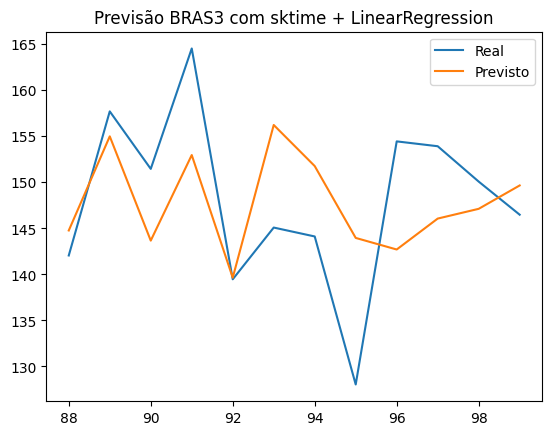

In [5]:
# Avaliar
from sklearn.metrics import mean_squared_error
print("RMSE:", mean_squared_error(y_test, y_pred))

# Visualizar
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label="Real")
plt.plot(y_test.index, y_pred, label="Previsto")
plt.legend()
plt.title("Previsão BRAS3 com sktime + LinearRegression")
plt.show()

C:\Users\mateu\AppData\Local\Temp\ipykernel_14532\4026379172.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2015-01-01", interval="1mo")[["Close"]].squeeze()
[*********************100%***********************]  1 of 1 completed
C:\Users\mateu\AppData\Local\Temp\ipykernel_14532\4026379172.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nasdaq = yf.download("^IXIC", start="2015-01-01", interval="1mo")[["Close"]].squeeze()
[*********************100%***********************]  1 of 1 completed
C:\Users\mateu\AppData\Local\Temp\ipykernel_14532\4026379172.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fed = yf.download("^IRX", start="2015-01-01", interval="1mo")[["Close"]].squeeze()
[*********************100%***********************]  1 of 1 completed
C:\Users\mateu\AppData\Local\Temp\ipykernel_14532\4026379172.py:13: FutureWarning: YF.downloa

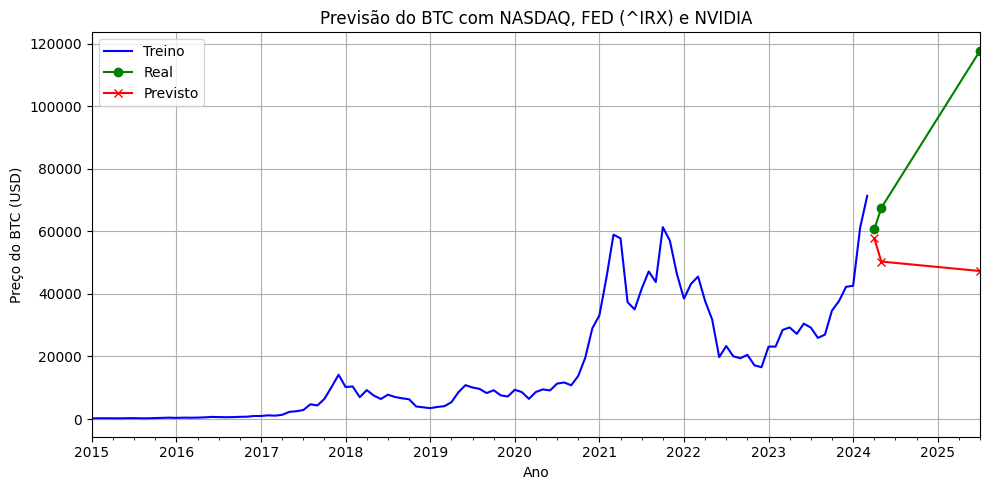

In [16]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.ensemble import RandomForestRegressor

# 1. Baixar dados mensais
btc = yf.download("BTC-USD", start="2015-01-01", interval="1mo")[["Close"]].squeeze()
nasdaq = yf.download("^IXIC", start="2015-01-01", interval="1mo")[["Close"]].squeeze()
fed = yf.download("^IRX", start="2015-01-01", interval="1mo")[["Close"]].squeeze()
nvidia = yf.download("NVDA", start="2015-01-01", interval="1mo")[["Close"]].squeeze()

# 2. Ajustar os índices para frequência mensal
for series in [btc, nasdaq, fed, nvidia]:
    series.index = pd.to_datetime(series.index).to_period("M")

# 3. Validar se os dados vieram corretamente
if any(s.empty for s in [btc, nasdaq, fed, nvidia]):
    raise ValueError("Erro ao baixar um ou mais conjuntos de dados.")

# 4. Juntar os dados
df = pd.concat([
    btc.rename("btc"),
    nasdaq.rename("nasdaq"),
    fed.rename("fed"),
    nvidia.rename("nvidia")
], axis=1).dropna()

# 5. Separar target (y) e features (X)
y = df["btc"]
X = df[["nasdaq", "fed", "nvidia"]]

# 6. Separar treino/teste com sktime
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=3)

# 7. Horizonte de previsão
fh = ForecastingHorizon(y_test.index, is_relative=False)

# 8. Criar e treinar o modelo
model = make_reduction(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    strategy="recursive",
    window_length=12,
    scitype="infer"
)

model.fit(y_train, X=X_train)

# 9. Prever os próximos 3 meses
y_pred = model.predict(fh, X=X_test)

# 10. Plotar resultado
plt.figure(figsize=(10, 5))
y_train.plot(label="Treino", color="blue")
y_test.plot(label="Real", marker="o", color="green")
y_pred.plot(label="Previsto", marker="x", color="red")
plt.title("Previsão do BTC com NASDAQ, FED (^IRX) e NVIDIA")
plt.ylabel("Preço do BTC (USD)")
plt.xlabel("Ano")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
